In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import zipfile

# Create a zip file object
zip_file = zipfile.ZipFile("/content/gdrive/MyDrive/ass3/A3_Dataset.zip")

# Extract all files from the zip file to the current directory
zip_file.extractall()

In [3]:
import matplotlib.pyplot as plt

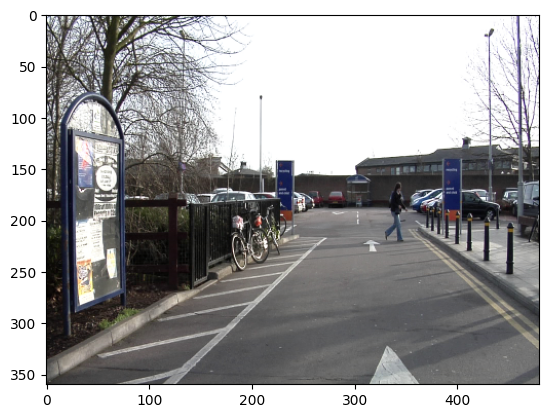

In [4]:
image_path = "A3_Dataset/dataset1/images_prepped_train/0006R0_f03840.png"

# Load the image.
image = plt.imread(image_path)

# Display the image.
plt.imshow(image)

# Show the image.
plt.show()

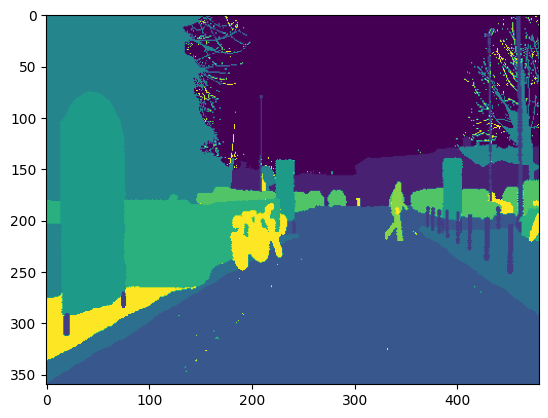

In [5]:
image_path = "A3_Dataset/dataset1/annotations_prepped_train/0006R0_f03840.png"

# Load the image.
image = plt.imread(image_path)

# Display the image.
plt.imshow(image)

# Show the image.
plt.show()

In [7]:
import os
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
# !pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp
from tqdm import tqdm

In [8]:

class SegmentationDataset(Dataset):
    def __init__(self, image_paths, annotation_paths, image_transform=None, annotation_transform=None):
        self.image_paths = image_paths
        self.annotation_paths = annotation_paths
        self.image_files = sorted(os.listdir(image_paths))
        
        self.image_transform = image_transform
        self.annotation_files= sorted(os.listdir(annotation_paths))
        self.annotation_transform = annotation_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_paths, img_name)
        
        ann_name = self.annotation_files[idx]
        ann_path = os.path.join(self.annotation_paths, img_name)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        annotation = cv2.imread(ann_path, 0)

        if self.image_transform:
            img = self.image_transform(img)

        if self.annotation_transform:
            # Replace the line below with OpenCV resizing using nearest-neighbor interpolation
            annotation = cv2.resize(annotation, (256, 256), interpolation=cv2.INTER_NEAREST)
            # Convert the annotation back to a tensor
            annotation = torch.from_numpy(annotation).long()

        return img, annotation


In [9]:
# Load dataset with separate transforms for images and annotations
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor()
])

annotation_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((256, 256)),
    transforms.ToTensor()])
batch_size = 16
dataset = SegmentationDataset("A3_Dataset/dataset1/images_prepped_train/", "A3_Dataset/dataset1/annotations_prepped_train/", image_transform, annotation_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


### UNET

In [37]:
# Initialize pre-trained model, loss function, and optimizer
# !pip install segmentation-models-pytorch

lr=0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [38]:
# Training loop


all_losses = []
epochs=25
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    running_loss = 0.0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    for i, (inputs, labels) in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update the progress bar
        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss = running_loss/(i+1))
    all_losses.append(running_loss)
    

Epoch 1/25


Epoch 2/25


Epoch 3/25


Epoch 4/25


Epoch 5/25


Epoch 6/25


Epoch 7/25


Epoch 8/25


Epoch 9/25


Epoch 10/25


Epoch 11/25


Epoch 12/25


Epoch 13/25


Epoch 14/25


Epoch 15/25


Epoch 16/25


Epoch 17/25


Epoch 18/25


Epoch 19/25


Epoch 20/25


Epoch 21/25


Epoch 22/25


Epoch 23/25


Epoch 24/25


Epoch 25/25


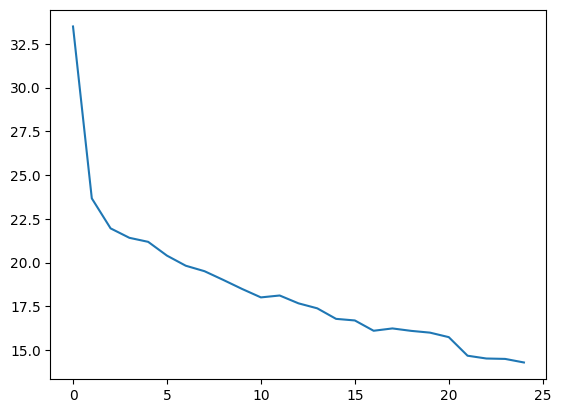

In [39]:
plt.plot(all_losses)

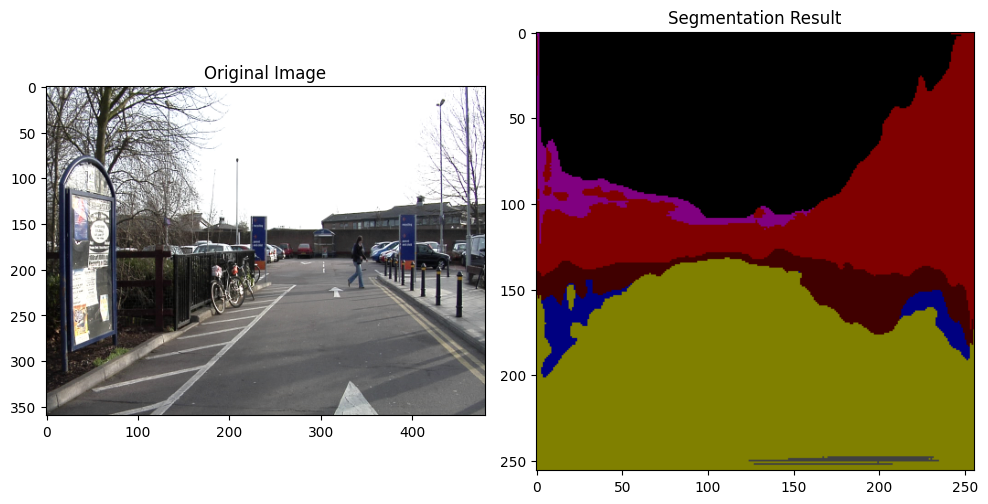

In [46]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
def postprocess_output(output, colormap):
    _, predicted = torch.max(output, 1)
    predicted = predicted.cpu().numpy().squeeze()
    return colormap[predicted]
    
# Load the image
image_path = "A3_Dataset/dataset1/images_prepped_train/0006R0_f03840.png"
img = cv2.imread(image_path)
preprocessed_img = image_transform(img)
x, y, z = preprocessed_img.shape
preprocessed_img = preprocessed_img.reshape(1, x, y, z)

# Inference
model.eval()
with torch.no_grad():
    inputs = preprocessed_img.to(device)
    outputs = model(inputs)

# Post-process the output
colormap = np.array([
    [0, 0, 0],        # Class 0: Background
    [128, 0, 0],      # Class 1
    [0, 128, 0],      # Class 2
    [128, 128, 0],    # Class 3
    [0, 0, 128],      # Class 4
    [128, 0, 128],    # Class 5
    [0, 128, 128],    # Class 6
    [128, 128, 128],  # Class 7
    [64, 0, 0],       # Class 8
    [192, 0, 0],      # Class 9
    [64, 128, 0], 
    [64, 64, 64]    # Class 10
], dtype=np.uint8) # Define your colormap here
result = postprocess_output(outputs, colormap)

# Visualize the result
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Original image
plt.title('Original Image')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(result)  # Model output
plt.title('Segmentation Result')

plt.tight_layout()
plt.show()

### DEEPLABV3

In [10]:
from torch.optim.lr_scheduler import StepLR
lr=0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.DeepLabV3Plus("resnet152", encoder_weights="imagenet", in_channels=3, classes=12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:02<00:00, 95.9MB/s]


In [27]:
all_losses = []
epochs=20
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    running_loss = 0.0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=False)
    for i, (inputs, labels) in loop:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update the progress bar
        running_loss += loss.item()
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss = running_loss/(i+1))

    scheduler.step()
    all_losses.append(running_loss)

Epoch 1/20


Epoch 2/20


Epoch 3/20


Epoch 4/20


Epoch 5/20


Epoch 6/20


Epoch 7/20


Epoch 8/20


Epoch 9/20


Epoch 10/20


Epoch 11/20


Epoch 12/20


Epoch 13/20


Epoch 14/20


Epoch 15/20


Epoch 16/20


Epoch 17/20


Epoch 18/20


Epoch 19/20


Epoch 20/20


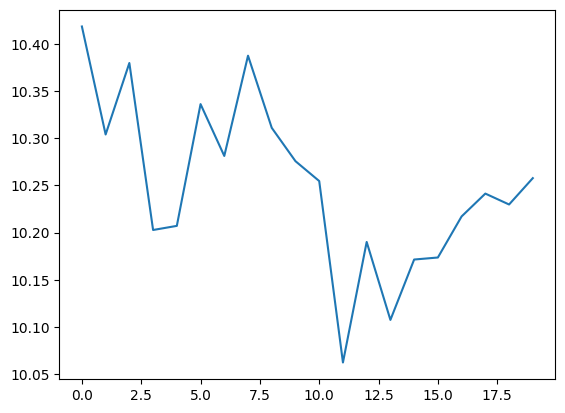

In [28]:
plt.plot(all_losses)

<ipython-input-29-95c8fae36323>:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 12)  # This gets the viridis colormap with n_colors discrete colors


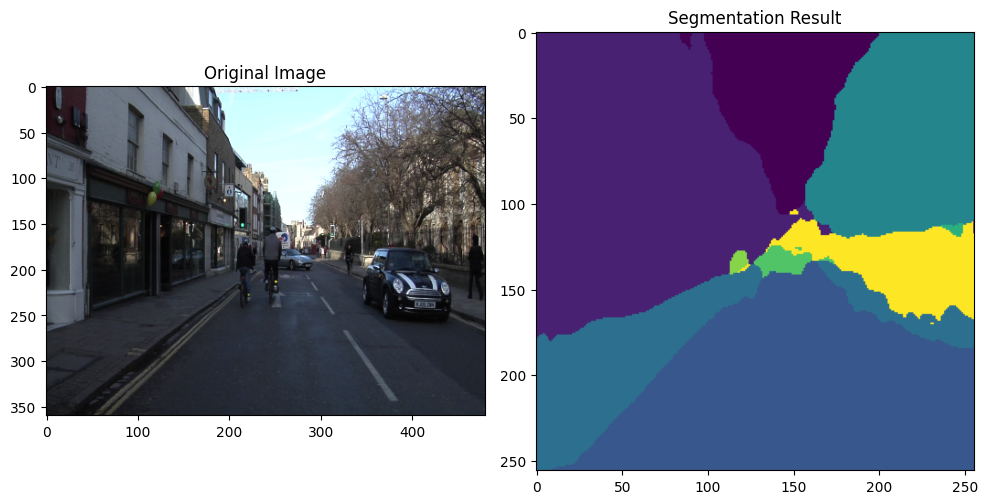

In [29]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def postprocess_output(output, colormap):
    _, predicted = torch.max(output, 1)
    predicted = predicted.cpu().numpy().squeeze()
    return colormap[predicted]
    
# Load the image
image_path = "A3_Dataset/dataset1/images_prepped_test/0016E5_07961.png"
img = cv2.imread(image_path)
preprocessed_img = image_transform(img)
x, y, z = preprocessed_img.shape
preprocessed_img = preprocessed_img.reshape(1, x, y, z)

# Inference
model.eval()
with torch.no_grad():
    inputs = preprocessed_img.to(device)
    outputs = model(inputs)

viridis = plt.cm.get_cmap('viridis', 12)  # This gets the viridis colormap with n_colors discrete colors

viridis_colors = viridis(np.linspace(0, 1, 12))  # Sample n_colors from the colormap

# Convert colors to 8-bit RGB for display purposes
colormap = (viridis_colors[:, :3] * 255).astype(np.uint8)  

result = postprocess_output(outputs, colormap)

# Visualize the result
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Original image
plt.title('Original Image')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(result)  # Model output
plt.title('Segmentation Result')

plt.tight_layout()
plt.show()

In [46]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous().view(-1)
    target = target.contiguous().view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Define your test dataset and dataloader here
test_dataset = SegmentationDataset("A3_Dataset/dataset1/images_prepped_test/", "A3_Dataset/dataset1/annotations_prepped_test/", image_transform, annotation_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.eval()  # Set the model to evaluation mode
dice_scores = []  # Store the dice scores for each batch

with torch.no_grad():  # Do not calculate gradients since we're not training
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the class with the highest probability

        # Calculate the dice score and append it to the list of dice scores
        dice_score = dice_coefficient(preds, labels)
        dice_scores.append(dice_score.item())

average_dice_score = sum(dice_scores) / len(dice_scores)
print(f'Average Dice Score: {average_dice_score}')



torch.Size([16, 256, 256])
torch.Size([16, 256, 256])
torch.Size([16, 256, 256])
torch.Size([16, 256, 256])
torch.Size([16, 256, 256])
torch.Size([16, 256, 256])
torch.Size([5, 256, 256])
Average Dice Score: 3.9814700399126326


In [39]:
dice_scores

[3.98640775680542,
 3.900170087814331,
 4.21873664855957,
 3.999347448348999,
 3.9789605140686035,
 3.9767050743103027,
 3.9629616737365723]